## 1. Импорт необходимых библиотек

#### Основные библиотеки

In [271]:
import sys
import numpy as np                # Для работы с массивами
import matplotlib.pyplot as plt

print('NumPy: ',numpy.__version__, '\n',
    'matplotlib: ',matplotlib.__version__, sep='')

NumPy: 1.19.2
SciPy: 1.5.0
matplotlib: 3.3.2


#### Библиотеки для работы с файлами SEGY

In [306]:
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader
from obspy.io.segy.core import _read_segy

#### Библиотеки для реализации преобразования Фурье

In [307]:
from numpy.fft import fft, rfft, rfftfreq     

#### Библиотека для создания помех сигнала (шума)

In [308]:
from numpy.random import uniform 

## 2. Создание функций

#### Функция для расчёта зависимости вида:

$$y(t)=A exp\big(-\big[\frac {t-t_0} {\tau} \big]^2\big)$$

In [309]:
A=50                                                #Амплитуда сигнала
t0=0.5                                              #Начальная точка
tau=0.02                                            #Параметр tau
t_start=0                                           #Первый элемент массива времени
t_finish=1                                          #Последний элемент массива времени
t_step=0.002                                        #Шаг по времени с которым производятся вычисления
tmas=np.arange(t_start,t_finish+t_step,t_step)      #Массив времени заданным шагом
N=len(tmas)                                         #Кол-во отсчётов

def make_signal():   
    data = A*np.exp(-((tmas-t0)/tau)**2)
    return data

#### Функция создания шума

In [310]:
a=50                                                 #Амплитуда шума

def make_noise():
    noise = uniform(-a,a,N)
    return noise

#### Функция создания "потока"

In [311]:
num_trace=10                                        #Количество трасс в одном потоке

def make_segy(n):
    for _i in range(num_trace):                        # Цикл вызывается каждый раз при создании новой трассы
        data = make_signal()
        if n==True:
            noise = make_noise()
            data = data + noise
        data = np.require(data, dtype=np.float32)
        trace = Trace(data=data)
        trace.stats.delta = t_step                 ## Атрибут trace.stats будет переписывать все в trace.stats.segy.trace_header. SEGY не поддерживает точность сотых долей секунды, они будут отброшены

        if not hasattr(trace.stats, 'segy.trace_header'):     ## Возвращает флаг, указывающий на то, содержит ли объект указанный атрибут hasattr(obj, name) -> bool
             trace.stats.segy = {}                            ## Словарь/набор
        trace.stats.segy.trace_header = SEGYTraceHeader()
        trace.stats.segy.trace_header.trace_sequence_number_within_line = _i + 1
        
        stream.append(trace)                             # Добавить трассу в stream
    
    stream.stats = AttribDict()
    stream.stats.textual_file_header = 'Textual Header!'
    stream.stats.binary_file_header = SEGYBinaryFileHeader()
    #print ("Объект stream перед записью...", '\n', stream)
    return stream, tmas

#### Функция для записи потока в SEGY

In [312]:
def write_segy(name,st):   
    st.write(name, format="SEGY", data_encoding=1, byteorder=sys.byteorder)

#### Функция получения данных из файла

In [313]:
def data_segy(name_file):
    STREAM = _read_segy(name_file)
    DATA = np.stack(t.data for t in STREAM.traces)
    print('Количество трасс: ', DATA.shape[0], '\n',
         'Количество элементов в каждой трассе: ', DATA.shape[1], sep='')
    return STREAM, DATA

#### Функция создания графика одной трассы

In [314]:
def print_one_trace(num,STREAM):
    y=STREAM.traces[num]
    plt.figure(figsize=(12, 4))
    plt.plot(tmas, y)
    plt.grid(True)
    plt.ylabel('Амплитуда')
    plt.xlabel('Время, сек')
    plt.show()
    return y

#### Функция построения амплитудных спектров

In [315]:
def make_AS(trace_num, name):
    spectrum = rfft(trace_num)
    X=rfftfreq(len(tmas), t_step)
    Y=np.abs(spectrum)/len(spectrum)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(X,Y)
    ax.grid(True)
    ax.set_ylabel('"Мощность"')
    ax.set_xlabel('Частота, Hz')
    plt.title(name)
    plt.show()

## 3. Начало расчётов

Создаём поток (без шума)

In [316]:
stream = Stream()
stream_no_noise, tmas = make_segy(n=False)

Записываем получившийся поток (без шума) в файл формата .sgy

In [317]:
write_segy("sig_no_noise.sgy",stream_no_noise)

Создаём поток (без шума)

In [318]:
stream = Stream()
stream_noise, tmas = make_segy(n=True)

Записываем получившийся поток (c шумом) в файл формата .sgy

In [319]:
write_segy("sig_noise.sgy",stream_noise)

In [320]:
STREAM_no_noise, DATA_no_noise = data_segy("sig_no_noise.sgy")

Количество трасс: 10
Количество элементов в каждой трассе: 501


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3417: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [321]:
STREAM_noise, DATA_noise = data_segy("sig_noise.sgy")

Количество трасс: 10
Количество элементов в каждой трассе: 501


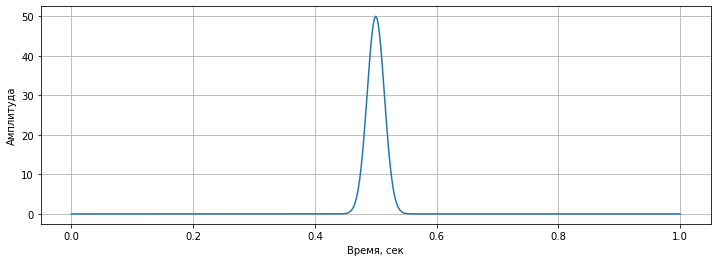

In [322]:
trace5_no_noise=print_one_trace(5,STREAM_no_noise)

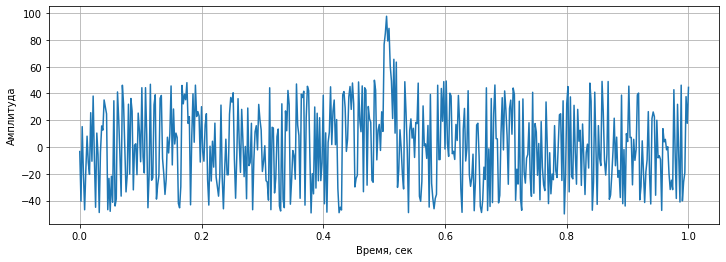

In [323]:
trace5_noise=print_one_trace(5,STREAM_noise)

Дискретное преобразование Фурье при помощи библиотеки NumPy

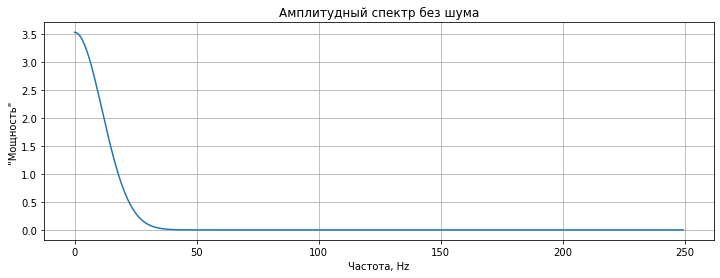

In [324]:
make_AS(trace5_no_noise, "Амплитудный спектр без шума")

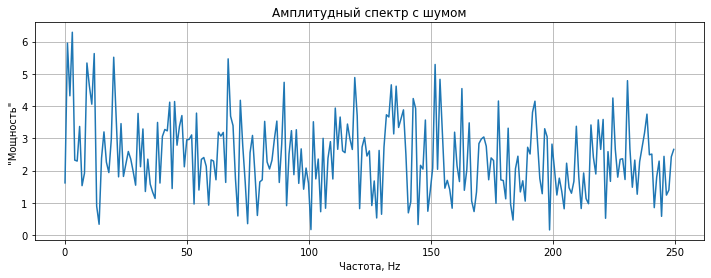

In [325]:
make_AS(trace5_noise, "Амплитудный спектр c шумом")

## 4. Проверка как влияет частота дискретизации на амплитудный спектр

In [326]:
def change_DT(dt):
    Tmas=np.arange(t_start,t_finish+dt,dt)
    Data = A*np.exp(-((Tmas-t0)/tau)**2)

    spectrum_test = rfft(Data)
    X_test=rfftfreq(len(Tmas), dt)
    Y_test=np.abs(spectrum_test)/len(spectrum_test)

    print("Время между точками {} сек; частота дискретизации {:.0f} Гц".format(dt, 1/dt))
    
    fig, ax = plt.subplots()
    ax.plot(Tmas, Data, label = dt)
    ax.plot(Tmas, Data, 'ro')
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Время, с')
    plt.legend()
    #plt.title('Амплитудный спектр')
    plt.show()
    
    print("Количество точек на первом графике {}; Количество точек на втором графике {:.0f}".format(len(Data), len(Y_test)))
    
    fig, ax = plt.subplots()
    ax.plot(X_test,Y_test, label = dt)
    ax.plot(X_test,Y_test, 'ro')
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Частота, Hz')
    plt.title('Амплитудный спектр')
    plt.legend()
    plt.show()

Время между точками 0.02 сек; частота дискретизации 50 Гц


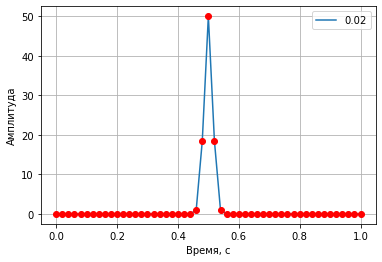

Количество точек на первом графике 51; Количество точек на втором графике 26


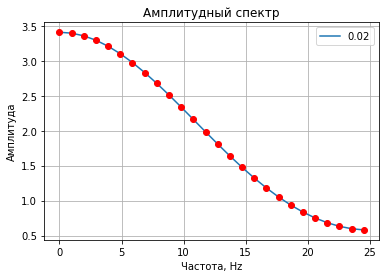

In [327]:
change_DT(0.02)

In [328]:
def change_dt(mas_dt):
    mas_Tmas=[[],[],[]]
    mas_data=[[],[],[]]
    X=[[],[],[]]
    Y=[[],[],[]]
    i=0
    while i<len(mas_dt):
        Tmas=np.arange(t_start,t_finish+mas_dt[i],mas_dt[i])
        mas_Tmas[i]=Tmas
        Data = A*np.exp(-((Tmas-t0)/tau)**2)
        mas_data[i]=Data

        spectrum_test = rfft(Data)
        X_test=rfftfreq(len(Tmas), mas_dt[i])
        X[i]=X_test
        Y_test=np.abs(spectrum_test)/len(spectrum_test)
        Y[i]=Y_test
        i+=1
        
    fig, ax = plt.subplots()
    ax.plot(mas_Tmas[0], mas_data[0], label = mas_dt[0])
    ax.plot(mas_Tmas[1], mas_data[1], label = mas_dt[1])
    ax.plot(mas_Tmas[2], mas_data[2], label = mas_dt[2])
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Время, с')
    plt.legend()
    #plt.title('Амплитудный спектр')
    ax.set_xlim(0.4, 0.6)
    plt.show()
        
    fig, ax = plt.subplots()
    ax.plot(X[0],Y[0], label = mas_dt[0])
    ax.plot(X[1],Y[1], label = mas_dt[1])
    ax.plot(X[2],Y[2], label = mas_dt[2])
    
    ax.grid(True)
    ax.set_ylabel('Амплитуда')
    ax.set_xlabel('Частота, Hz')
    plt.title('Амплитудный спектр')
    plt.legend()
    ax.set_xlim(-5, 50)
    plt.show()

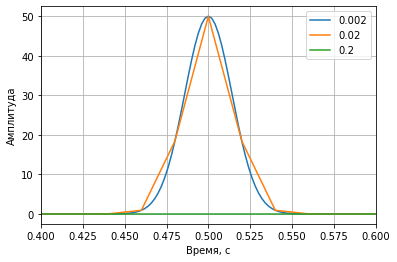

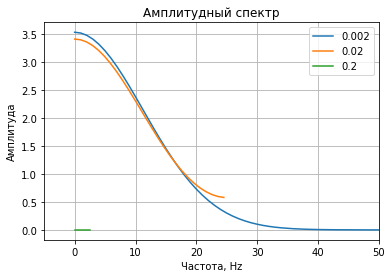

In [329]:
change_dt([0.002,0.02,0.2])